## Dependencias

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from tqdm import tqdm
from keras.layers import Dense, Activation, Reshape, Dropout, Flatten, Input, Lambda
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import cv2

%matplotlib inline

## Clonar o repositório do projeto

In [0]:
%cd /content/
!git clone https://github.com/Larissa13/MAC5749.git

import sys
if not 'MAC5749' in sys.path:
  sys.path.append('MAC5749')

/content
Cloning into 'MAC5749'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 12758 (delta 40), reused 70 (delta 17), pack-reused 12661
Receiving objects: 100% (12758/12758), 159.63 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (2463/2463), done.
Checking out files: 100% (9894/9894), done.


## Carregar o dataset e separa treinamento, validação e testes


In [0]:
from sarpy.datasets import load_emnist

images, labels, images_test, labels_test, images_valid, labels_valid, mapping, nb_classes = load_emnist('balanced')

# 30% of the data is for validation
valid_split = 0.2
valid_size = int(len(images) * valid_split)

images_valid = images[:valid_size]
labels_valid = labels[:valid_size]

images_train = images[valid_size:]
labels_train = labels[valid_size:]


images_train = np.concatenate((images_train, images_train, images_train), 3).astype('uint8')
labels_train = labels_train.squeeze()
print('images_train shape:', images_train.shape)
print('labels_train shape:', labels_train.shape)

images_valid = np.concatenate((images_valid, images_valid, images_valid), 3).astype('uint8')
labels_valid = labels_valid.squeeze()
print('images_valid shape:', images_valid.shape)
print('labels_valid shape:', labels_valid.shape)

images_test = np.concatenate((images_test, images_test, images_test), 3).astype('uint8')
labels_test = labels_test.squeeze()
print('images_test shape:', images_test.shape)
print('labels_test shape:', labels_test.shape)

reshape testing: 100%|██████████| 18800/18800 [00:00<00:00, 39775.21it/s]


Train size: 112800
Test size: 18800
Validation size: 0
# classes: 47
images_train shape: (90240, 28, 28, 3)
labels_train shape: (90240,)
images_valid shape: (22560, 28, 28, 3)
labels_valid shape: (22560,)
images_test shape: (18800, 28, 28, 3)
labels_test shape: (18800,)


## Mostra um exemplo

6


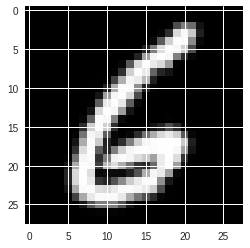

In [0]:
plt.imshow(images_test[16])
print(labels_test[16])

# Monta conjuntos

### Save the training images to  ```balanced-images-train```



In [0]:
folder_images = 'balanced-images-train'

if not os.path.exists(folder_images):
  os.mkdir(folder_images)
  
for label in labels_train:
    if not os.path.isdir(os.path.join(folder_images, str(label))):
      os.mkdir(os.path.join(folder_images, str(label)))
      
for i in tqdm(range(images_train.shape[0]), desc="Saving training images to %s..."%folder_images):
    img_filename = os.path.join(folder_images, str(labels_train[i]), str(i)) + ".png"
    
    if not os.path.exists(img_filename):
      scipy.misc.imsave(img_filename, images_train[i])

Saving training images to balanced-images-train...:   0%|          | 0/90240 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
Saving training images to balanced-images-train...: 100%|██████████| 90240/90240 [00:45<00:00, 1970.88it/s]


### Save the training images to  ```balanced-images-train```


In [0]:
folder_images = 'balanced-images-valid'

if not os.path.exists(folder_images):
  os.mkdir(folder_images)
  
for label in labels_valid:
    if not os.path.isdir(os.path.join(folder_images, str(label))):
      os.mkdir(os.path.join(folder_images, str(label)))
      
for i in tqdm(range(images_valid.shape[0]), desc="Saving validation images to %s..."%folder_images):
    img_filename = os.path.join(folder_images, str(labels_valid[i]), str(i)) + ".png"
    
    if not os.path.exists(img_filename):
      scipy.misc.imsave(img_filename, images_valid[i])

Saving validation images to balanced-images-valid...:   0%|          | 0/22560 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
Saving validation images to balanced-images-valid...: 100%|██████████| 22560/22560 [00:11<00:00, 1984.22it/s]


### Save the training images to  ```balanced-images-test```

In [0]:
folder_images = 'balanced-images-test'

if not os.path.exists(folder_images):
  os.mkdir(folder_images)
  
for label in labels_test:
    if not os.path.isdir(os.path.join(folder_images, str(label))):
      os.mkdir(os.path.join(folder_images, str(label)))    

for i in tqdm(range(images_test.shape[0]), desc="Saving training images to %s..."%folder_images):
    img_filename = os.path.join(folder_images, str(labels_test[i]), str(i)) + ".png"
    
    if not os.path.exists(img_filename):
      scipy.misc.imsave(img_filename, images_test[i])

Saving training images to balanced-images-test...:   0%|          | 0/18800 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
Saving training images to balanced-images-test...: 100%|██████████| 18800/18800 [00:09<00:00, 2043.68it/s]


# VGG

In [0]:
from keras.applications import vgg16

NUM_LABELS = 47 # ByMerge
IMAGE_SHAPE = (32, 32, 3)

def rebuild_vgg(num_labels=NUM_LABELS, input_shape=IMAGE_SHAPE, model=None):
  
    input = Input(shape = input_shape)
  
    if model == None:
        model = vgg16.VGG16(input_tensor = input,
                            weights='imagenet',
                            include_top = False)
    
    flatten = Flatten()(model.layers[-1].output)
    output = Dense(num_labels, activation='softmax')(flatten)

    new_model = Model(input, output)
    
    new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

    new_model.summary()

    return new_model
  
new_vgg = rebuild_vgg()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
train_dirname = 'balanced-images-train'
validation_dirname = 'balanced-images-valid'

vgg_train_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = vgg16.preprocess_input)
vgg_validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = vgg16.preprocess_input)

vgg_train_generator = vgg_train_datagen.flow_from_directory(
        train_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

vgg_validation_generator = vgg_validation_datagen.flow_from_directory(
        validation_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=8,
        class_mode='categorical')

new_vgg.fit_generator(vgg_train_generator, steps_per_epoch=100,
                    epochs=30,
                    validation_data=vgg_validation_generator,
                    validation_steps=50)

Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.
Epoch 1/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5390 - acc: 0.8175 - val_loss: 0.5322 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5638 - acc: 0.8166 - val_loss: 0.6281 - val_acc: 0.7875
Epoch 3/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5434 - acc: 0.8231 - val_loss: 0.5955 - val_acc: 0.8150
Epoch 4/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5371 - acc: 0.8284 - val_loss: 0.7290 - val_acc: 0.8000
Epoch 5/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5506 - acc: 0.8184 - val_loss: 0.5709 - val_acc: 0.8000
Epoch 6/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5603 - acc: 0.8159 - val_loss: 0.5755 - val_acc: 0.7825
Epoch 7/30
100/100 [==============================] - 9s 88ms/step - loss: 0.5325 - acc: 0.8238 - val_loss: 0.5270

## Avaliando VGG16 no conjunto de teste

In [0]:
test_dirname = 'balanced-images-test'

vgg_test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = vgg16.preprocess_input)

vgg_test_generator = vgg_test_datagen.flow_from_directory(
        test_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

test_loss, test_acc = new_vgg.evaluate_generator(vgg_test_generator, steps = len(images_test) / 32, verbose = 1)

print('Acurácia no conjunto de teste:', test_acc)

Found 18800 images belonging to 47 classes.
588/587 [==============================] - 12s 21ms/step
Acurácia no conjunto de teste: 0.838404255319149


# Resnet50

In [0]:
from keras.applications import resnet50

def rebuild_resnet(labels=NUM_LABELS, input_shape=IMAGE_SHAPE, model=None):
    
    input = Input(shape = input_shape)
  
    if model == None:
        model = resnet50.ResNet50(input_tensor = input,
                                  include_top = False,
                                  weights='imagenet')

    flatten = Flatten()(model.layers[-1].output)
    output = Dense(labels, activation='softmax')(flatten)

    new_model = Model(input, output)
    
    new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

    new_model.summary()

    return new_model
  
new_resnet = rebuild_resnet()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
resnet_train_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = resnet50.preprocess_input)
resnet_validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = resnet50.preprocess_input)

resnet_train_generator = resnet_train_datagen.flow_from_directory(
        train_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

resnet_validation_generator = resnet_validation_datagen.flow_from_directory(
        validation_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=8,
        class_mode='categorical')

new_resnet.fit_generator(resnet_train_generator, steps_per_epoch=100,
                          epochs=30,
                          validation_data=resnet_validation_generator,
                          validation_steps=50)

Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.
Epoch 1/30
100/100 [==============================] - 25s 251ms/step - loss: 2.4872 - acc: 0.4166 - val_loss: 9.4095 - val_acc: 0.1350
Epoch 2/30
100/100 [==============================] - 23s 228ms/step - loss: 2.8375 - acc: 0.3341 - val_loss: 15.7957 - val_acc: 0.0200
Epoch 3/30
100/100 [==============================] - 23s 228ms/step - loss: 2.5015 - acc: 0.4141 - val_loss: 2.3185 - val_acc: 0.3900
Epoch 4/30
100/100 [==============================] - 23s 227ms/step - loss: 2.0364 - acc: 0.5097 - val_loss: 4.7702 - val_acc: 0.1425
Epoch 5/30
100/100 [==============================] - 23s 226ms/step - loss: 2.0188 - acc: 0.4909 - val_loss: 1.9284 - val_acc: 0.5000
Epoch 6/30
100/100 [==============================] - 23s 225ms/step - loss: 1.5106 - acc: 0.5875 - val_loss: 1.7398 - val_acc: 0.4900
Epoch 7/30
100/100 [==============================] - 23s 225ms/step - loss: 2.0118 - acc: 0.5047 - v

## Avaliando Resnet50 no conjunto de teste

In [0]:
test_dirname = 'balanced-images-test'

resnet_test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = resnet50.preprocess_input)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        test_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

test_loss, test_acc = new_resnet.evaluate_generator(resnet_test_generator, steps = len(images_test) / 32, verbose = 1)

print('Acurácia no conjunto de teste:', test_acc)

Found 18800 images belonging to 47 classes.
588/587 [==============================] - 22s 37ms/step
Acurácia no conjunto de teste: 0.7996808510638298


# MobileNet

In [0]:
from keras.applications import mobilenet

def rebuild_mobilenet(labels=NUM_LABELS, input_shape=IMAGE_SHAPE, model=None):
      
    input = Input(shape = input_shape)
  
    if model == None:
        model = mobilenet.MobileNet(input_tensor = input,
                                    include_top = False,
                                    weights='imagenet')
        
    flatten = Flatten()(model.layers[-1].output)
    output = Dense(labels, activation='softmax')(flatten)

    new_model = Model(input, output)
    
    new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

    new_model.summary()

    return new_model
  
new_mobilenet = rebuild_mobilenet()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
__________

In [0]:
mobilenet_train_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = mobilenet.preprocess_input)
mobilenet_validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = mobilenet.preprocess_input)

mobilenet_train_generator = mobilenet_train_datagen.flow_from_directory(
        train_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

mobilenet_validation_generator = mobilenet_validation_datagen.flow_from_directory(
        validation_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=8,
        class_mode='categorical')

new_mobilenet.fit_generator(mobilenet_train_generator, steps_per_epoch=100,
                            epochs=30,
                            validation_data=mobilenet_validation_generator,
                            validation_steps=50)

Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.
Epoch 1/30
100/100 [==============================] - 16s 157ms/step - loss: 3.0945 - acc: 0.3228 - val_loss: 4.0228 - val_acc: 0.3275
Epoch 2/30
100/100 [==============================] - 8s 81ms/step - loss: 1.8318 - acc: 0.5369 - val_loss: 1.9718 - val_acc: 0.5250
Epoch 3/30
100/100 [==============================] - 8s 80ms/step - loss: 1.4508 - acc: 0.6088 - val_loss: 1.4333 - val_acc: 0.6075
Epoch 4/30
100/100 [==============================] - 8s 80ms/step - loss: 1.4562 - acc: 0.6291 - val_loss: 1.5180 - val_acc: 0.5850
Epoch 5/30
100/100 [==============================] - 8s 80ms/step - loss: 1.2515 - acc: 0.6666 - val_loss: 1.0305 - val_acc: 0.7100
Epoch 6/30
100/100 [==============================] - 8s 81ms/step - loss: 1.0815 - acc: 0.6912 - val_loss: 1.1620 - val_acc: 0.7025
Epoch 7/30
100/100 [==============================] - 8s 80ms/step - loss: 1.0136 - acc: 0.7037 - val_loss: 0.89

## Avaliando a Mobilenet no conjunto de teste

In [0]:
test_dirname = 'balanced-images-test'

mobilenet_test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = mobilenet.preprocess_input)

mobilenet_test_generator = mobilenet_test_datagen.flow_from_directory(
        test_dirname,
        target_size=IMAGE_SHAPE[:2],
        batch_size=32,
        class_mode='categorical')

test_loss, test_acc = new_mobilenet.evaluate_generator(mobilenet_test_generator, steps = len(images_test) / 32, verbose = 1)

print('Acurácia no conjunto de teste:', test_acc)

Found 18800 images belonging to 47 classes.
588/587 [==============================] - 12s 20ms/step
Acurácia no conjunto de teste: 0.8220744680851064


# Inception V3

In [0]:
from keras.applications import inception_v3

def rebuild_inception(labels=NUM_LABELS, input_shape=(128, 128, 3), model=None):
  
    input = Input(shape = input_shape)
  
    if model == None:
        model = inception_v3.InceptionV3(input_tensor = input,
                                         include_top = False,
                                         weights='imagenet')

    model.summary()
        
    flatten = Flatten()(model.layers[-1].output)
    output = Dense(labels, activation='softmax')(flatten)

    new_model = Model(input, output)
    
    new_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

    new_model.summary()

    return new_model
  
new_inception = rebuild_inception()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
inception_train_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = inception_v3.preprocess_input)
inception_validation_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = inception_v3.preprocess_input)

inception_train_generator = inception_train_datagen.flow_from_directory(
        train_dirname,
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

inception_validation_generator = inception_validation_datagen.flow_from_directory(
        validation_dirname,
        target_size=(128, 128),
        batch_size=9,
        class_mode='categorical')

new_inception.fit_generator(inception_train_generator, steps_per_epoch=100,
                            epochs=30,
                            validation_data=inception_validation_generator,
                            validation_steps=50)

Found 90240 images belonging to 47 classes.
Found 22560 images belonging to 47 classes.
Epoch 1/30
100/100 [==============================] - 54s 536ms/step - loss: 2.9041 - acc: 0.3310 - val_loss: 8.3057 - val_acc: 0.2667
Epoch 2/30
100/100 [==============================] - 30s 299ms/step - loss: 1.5576 - acc: 0.5905 - val_loss: 4.0646 - val_acc: 0.4489
Epoch 3/30
100/100 [==============================] - 30s 300ms/step - loss: 1.1389 - acc: 0.6785 - val_loss: 3.1805 - val_acc: 0.5022
Epoch 4/30
100/100 [==============================] - 30s 302ms/step - loss: 0.9831 - acc: 0.6875 - val_loss: 8.4002 - val_acc: 0.3089
Epoch 5/30
100/100 [==============================] - 30s 300ms/step - loss: 0.8544 - acc: 0.7300 - val_loss: 1.1744 - val_acc: 0.7244
Epoch 6/30
100/100 [==============================] - 30s 303ms/step - loss: 0.7904 - acc: 0.7450 - val_loss: 1.0632 - val_acc: 0.7422
Epoch 7/30
100/100 [==============================] - 30s 302ms/step - loss: 0.6890 - acc: 0.7900 - va

## Avaliando a Inception V3 no conjunto de teste

In [0]:
test_dirname = 'balanced-images-test'

inception_test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = inception_v3.preprocess_input)

inception_test_generator = inception_test_datagen.flow_from_directory(
        test_dirname,
        target_size=(128, 128IMAGE_SHAPE[:2]),
        batch_size=32,
        class_mode='categorical')

test_loss, test_acc = new_inception.evaluate_generator(inception_test_generator, steps = len(images_test) / 32, verbose = 1)

print('Acurácia no conjunto de teste:', test_acc)

Found 18800 images belonging to 47 classes.
588/587 [==============================] - 45s 76ms/step
Acurácia no conjunto de teste: 0.7425531914893617
